# Getting Norm Notebook

In [1]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setup
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
profile = pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
align_to = rs.stream.color
align = rs.align(align_to)

In [82]:
frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
aligned_depth_frame = aligned_frames.get_depth_frame()

# Preprocessing
dec_filter = rs.decimation_filter()
dec_filter.set_option(rs.option.filter_magnitude, 4)

spa_filter = rs.spatial_filter()
spa_filter.set_option(rs.option.filter_magnitude, 5)
spa_filter.set_option(rs.option.filter_smooth_alpha, 1)
spa_filter.set_option(rs.option.filter_smooth_delta, 50)
spa_filter.set_option(rs.option.holes_fill, 3)

tmp_filter = rs.temporal_filter()
hol_fillin = rs.hole_filling_filter()

dep_to_dis = rs.disparity_transform(True)
dis_to_dep = rs.disparity_transform(False)

aligned_depth_frame = dec_filter.process(aligned_depth_frame)
aligned_depth_frame = dep_to_dis.process(aligned_depth_frame)
aligned_depth_frame = spa_filter.process(aligned_depth_frame)
aligned_depth_frame = tmp_filter.process(aligned_depth_frame)
aligned_depth_frame = dis_to_dep.process(aligned_depth_frame)
aligned_depth_frame = hol_fillin.process(aligned_depth_frame)

color_frame = aligned_frames.get_color_frame()
depth_image = np.asanyarray(aligned_depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

## Analyze Color Image

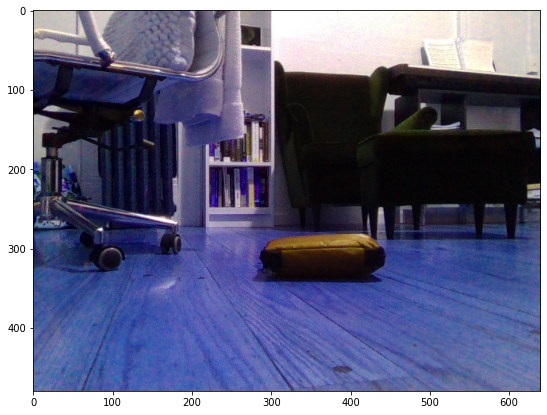

In [83]:
plt.figure(figsize=(10, 7))
plt.imshow(color_image)
plt.show()

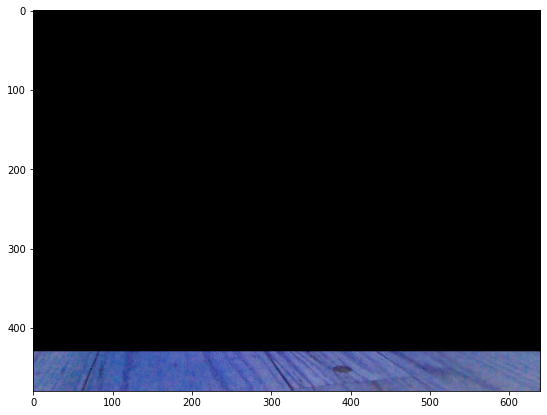

In [84]:
start = np.array([430, 0])
end   = np.array([480, 640])

edit_color = np.array(color_image)
edit_color[:start[0], :, :] = 0
edit_color[end[0]:  , :, :] = 0
edit_color[:, :start[1], :] = 0
edit_color[:,   end[1]:, :] = 0

plt.figure(figsize=(10, 7))
plt.imshow(edit_color)
plt.show()

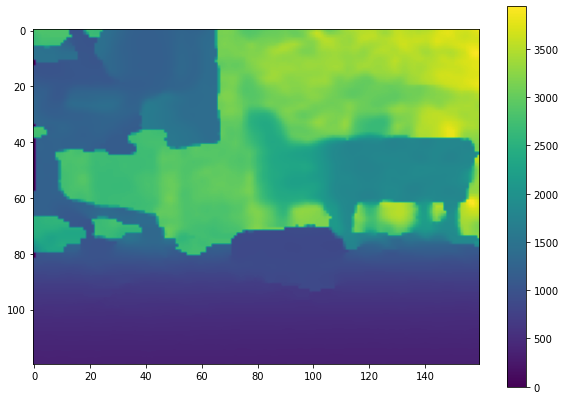

In [85]:
plt.figure(figsize=(10, 7))
plt.imshow(depth_image)
plt.colorbar()
plt.show()

In [86]:
edit_depth = np.array(depth_image)
edit_depth[:int(start[0] / 4), :] = 0
edit_depth[int(end[0] / 4):  , :] = 0
edit_depth[:, :int(start[1] / 4)] = 0
edit_depth[:,  int(end[1] / 4) :] = 0

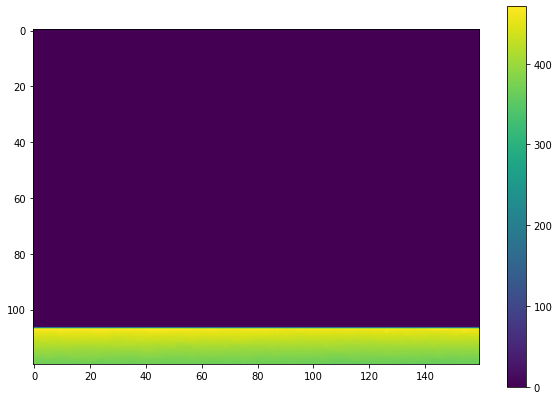

In [87]:
plt.figure(figsize=(10, 7))
plt.imshow(edit_depth)
plt.colorbar()
plt.show()

## Get Reference Norm from Depth

In [88]:
pc = rs.pointcloud()
points = pc.calculate(aligned_depth_frame)
vtx = np.ndarray(
    buffer=points.get_vertices(), dtype=np.float32, 
    shape=(int(640 / 4) * int(480 / 4), 3)
)

In [89]:
select_idx = (edit_depth > 0).flatten()
select_idx

array([False, False, False, ...,  True,  True,  True])

In [90]:
ref_sample = vtx[select_idx]
ref_mean = ref_sample.mean(axis=0)

In [91]:
_, _, vt = np.linalg.svd(ref_sample - ref_mean)

In [92]:
norm = vt[2]
norm

array([ 0.00609959,  0.9999755 , -0.00343259], dtype=float32)

## Test Norm on Depth Image

In [93]:
color_image.shape

(480, 640, 3)

In [94]:
def normalize_v3(arr):
    lens = np.sqrt(arr[:, 0]**2 + arr[:,1]**2 + arr[:,2]**2) + 1e-10
    arr[:,0] /= lens
    arr[:,1] /= lens
    arr[:,2] /= lens
    return arr

d1, d2, _ = color_image.shape
d1, d2 = int(d1 / 4), int(d2 / 4)
idx, jdx = np.indices((d1, d2))
idx_back = np.clip(idx - 1, 0, idx.max()).flatten()
idx_front = np.clip(idx + 1, 0, idx.max()).flatten()
jdx_back = np.clip(jdx - 1, 0, jdx.max()).flatten()
jdx_front = np.clip(jdx + 1, 0, jdx.max()).flatten()
idx = idx.flatten()
jdx = jdx.flatten()

f1 = (idx_front * d2 + jdx)
f2 = (idx_back  * d2 + jdx)
f3 = (idx * d2 + jdx_front)
f4 = (idx * d2 + jdx_back )
norm_fill = np.zeros((idx.shape[0]))

In [95]:
x = vtx[f1, :] - vtx[f2, :]
y = vtx[f3, :] - vtx[f4, :]
xyz_norm = normalize_v3(np.cross(x, y)) # N x 3
norm_flat = xyz_norm @ norm # N x 1
norm_matrix = np.abs(norm_flat.reshape((d1, d2))) # d1 x d2

In [96]:
import cv2

norm_umatrix = cv2.resize(cv2.UMat(norm_matrix), (d2 * 4, d1 * 4))
bool_matrix = cv2.compare(norm_umatrix, 0.97, cmpop=cv2.CMP_GT) # norm_umatrix > 0.97
edit_color2 = np.array(color_image) 
edit_color2[bool_matrix.get() == 255] = 255 # 

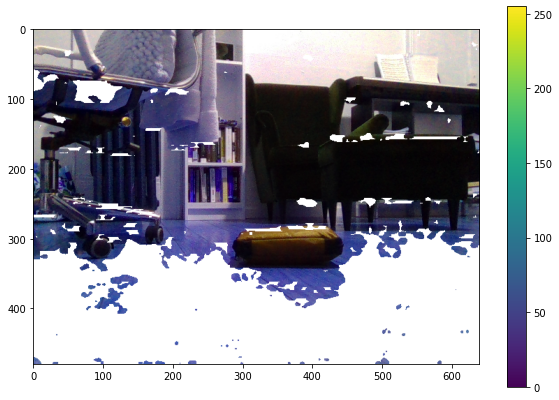

In [97]:
plt.figure(figsize=(10, 7))
plt.imshow(edit_color2)
plt.colorbar()
plt.show()

## Flood Fill Actual Algorithm

In [98]:
mat3d = xyz_norm.reshape((d1, d2, 3))
mask = np.zeros((mat3d.shape[0] + 2, mat3d.shape[1] + 2), np.uint8)

In [99]:
mat3d.shape

(120, 160, 3)

In [100]:
_, retval, _, _ = cv2.floodFill(
    mat3d, mask=mask, seedPoint=(119, 80), newVal=(0.0, 0.0, 0.0), 
    loDiff=(1, 1, 1), upDiff=(1, 1, 1),)

In [101]:
retval.shape

(120, 160, 3)

In [102]:
ret_comps = np.mean(retval, axis=2) < 0.0001
ret_comps = ret_comps * np.mean(retval, axis=2) > -0.0001

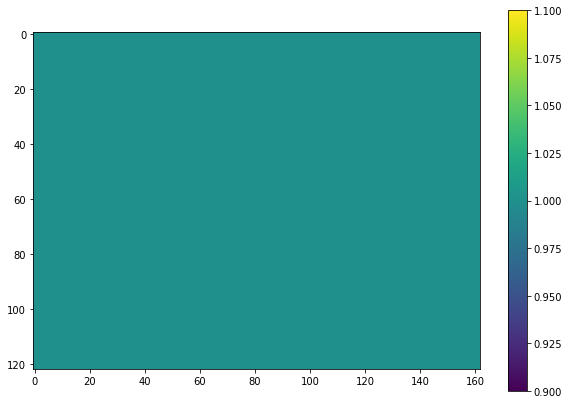

In [103]:
plt.figure(figsize=(10, 7))
plt.imshow(mask)
plt.colorbar()
plt.show()

In [104]:
from cv2 import connectedComponentsWithStats as getConnects

bool_matrix = cv2.UMat(mask)
comps, out, stats, cents = getConnects(bool_matrix, connectivity=4)
sizes = stats.get()[:, -1]
print(sizes, comps)
max_label = max_label = np.argmax(sizes[1:comps]) + 1

[    0 19764] 2


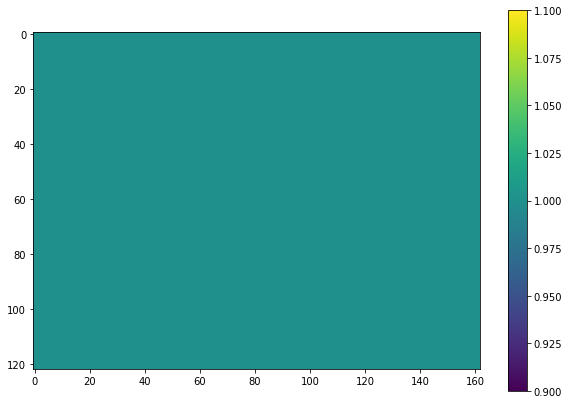

In [105]:
plt.figure(figsize=(10, 7))
plt.imshow(out.get() == max_label)
plt.colorbar()
plt.show()

## Get Largest Connected Component

In [19]:
from cv2 import connectedComponentsWithStats as getConnects

comps, out, stats, cents = getConnects(bool_matrix, connectivity=4)
sizes = stats.get()[:, -1]
max_label = max_label = np.argmax(sizes[2:comps]) + 2
        
edit_color3 = np.array(color_image)
edit_color3[out.get() == max_label] = 255

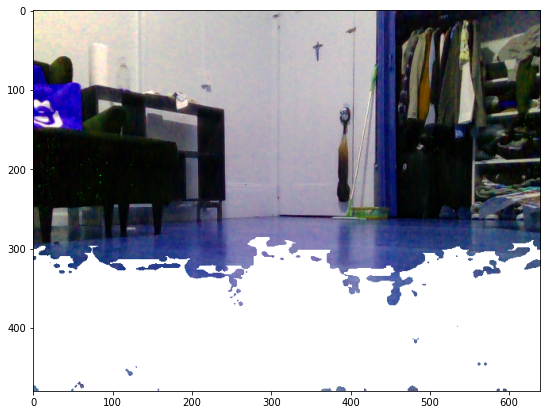

In [20]:
plt.figure(figsize=(10, 7))
plt.imshow(edit_color3)
plt.show()